### Results For paper

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [3]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [4]:
np.random.seed(seed = 0)

### Load Data

In [5]:
# s3_path = 'nneehal/DATA/odata/m6_propens_no_cluster_only_latent'
# data_path = '../temp'

# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

In [6]:
%%time
p = '../temp/odata_prop/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 191 ms, sys: 137 ms, total: 328 ms
Wall time: 344 ms


In [7]:
### Optional(filter registrations after  a particular month and before a particular month)

In [8]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [9]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [10]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [11]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [12]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [13]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 13.6 s, sys: 71.4 ms, total: 13.7 s
Wall time: 13.7 s


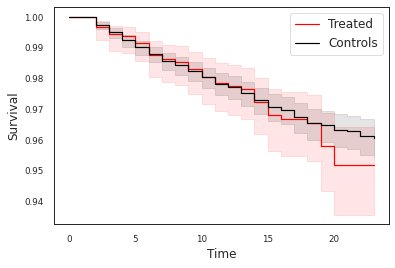

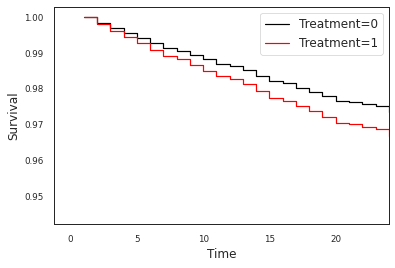

In [14]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [15]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        0.571049  0.449842  1.152509

In [16]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      3.040           0.472        6.445    0.000
Gender                   0.336           0.130        2.582    0.010
Total Cost               0.196           0.088        2.232    0.026
Tobacco use              0.578           0.205        2.819    0.005
Obesity                  0.563           0.138        4.089    0.000
Hypertension             0.223           0.153        1.460    0.144
Hypothyroid             -0.593           0.275       -2.157    0.031
Disease Count           -0.824           0.598       -1.379    0.168
Line of Bussiness       -0.435           0.209       -2.080    0.038
Treatment                0.234           0.159        1.472    0.141

### ER

In [17]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [18]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.7 s, sys: 36 ms, total: 13.7 s
Wall time: 13.7 s


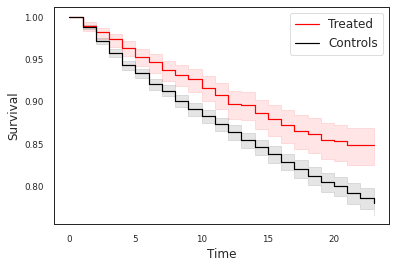

In [19]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [20]:
lrsumm

test_statistic         p   -log2(p)
ER       20.060171  0.000008  17.023845

In [21]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.293           0.186       -6.940    0.000
Gender                  -0.110           0.063       -1.752    0.080
Total Cost               0.165           0.039        4.187    0.000
Tobacco use              0.273           0.088        3.116    0.002
Obesity                 -0.128           0.062       -2.071    0.038
Hypertension             0.083           0.073        1.131    0.258
Hypothyroid             -0.097           0.100       -0.974    0.330
Disease Count            2.038           0.237        8.588    0.000
Line of Bussiness       -0.795           0.070      -11.296    0.000
Treatment               -0.278           0.080       -3.489    0.000

### IP

In [22]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [23]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.7 s, sys: 29.4 ms, total: 13.8 s
Wall time: 13.8 s


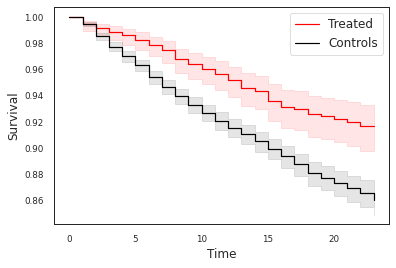

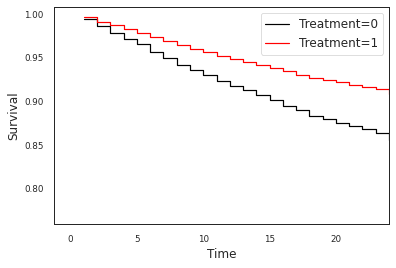

In [24]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [25]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7f0c78ed9278>>

In [26]:
lrsumm

test_statistic             p   -log2(p)
IP        25.59777  4.205251e-07  21.181305

In [27]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -0.067           0.238       -0.283    0.777
Gender                  -0.122           0.080       -1.535    0.125
Total Cost               0.355           0.056        6.321    0.000
Tobacco use              0.035           0.113        0.311    0.756
Obesity                 -0.181           0.077       -2.348    0.019
Hypertension            -0.088           0.088       -0.995    0.320
Hypothyroid             -0.318           0.122       -2.607    0.009
Disease Count            3.174           0.271       11.697    0.000
Line of Bussiness       -0.426           0.098       -4.327    0.000
Treatment               -0.487           0.107       -4.541    0.000

### Acute Care IP OR ER

In [28]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [29]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.9 s, sys: 22.9 ms, total: 13.9 s
Wall time: 13.9 s


In [30]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [31]:
lrsumm

test_statistic             p   -log2(p)
Acute       37.147524  1.095217e-09  29.766136

In [32]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -0.915           0.159       -5.748    0.000
Gender                  -0.152           0.054       -2.816    0.005
Total Cost               0.220           0.034        6.413    0.000
Tobacco use              0.199           0.076        2.607    0.009
Obesity                 -0.132           0.052       -2.512    0.012
Hypertension             0.006           0.061        0.094    0.925
Hypothyroid             -0.211           0.086       -2.466    0.014
Disease Count            2.478           0.201       12.356    0.000
Line of Bussiness       -0.641           0.063      -10.239    0.000
Treatment               -0.377           0.069       -5.464    0.000

### Load all Log Rank Sums in a matrix

In [33]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [34]:
df2

logRank statistic       p-value  RMST difference
Diabetes                   0.571049  4.498422e-01        -0.049080
Emergency Visits          20.060171  7.504334e-06         0.836221
Inpatient Vistis          25.597770  4.205251e-07         0.759028
Acute Care                37.147524  1.095217e-09         1.318275